Experiment to test whether the model can predict the gender of a word based on its context at inference time, even when it has seen no gendered occurrences of the word at train time.

Trains 20 models and outputs the average accuracy for each category of noun. Computes the mean and median probability of correct and incorrect predictions for each category.

## Requirements

In [1]:
import json
from collections import defaultdict
from pcfg import PCFG
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pathlib
import tempfile
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from IPython.utils import io
import re
import os

In [111]:
device = 'cuda:0'

## Get vocabulary

In [112]:
with open('full_vocabulary.json', 'r') as openfile:
    full_vocab = json.load(openfile)

## Create train model PCFG

In [113]:
# Non-terminal productions
non_terminal_rules = """
S -> NP VP "."[1.0]

PP -> PREP NP [1.0]
VP -> VERB [0.5] | VERB NP [0.5]

NP -> NPGend [0.4] | NPAmb [0.4] | NP PP [0.20]

NPGend -> DETFem npGendFem [0.5] | DETMasc npGendMasc [0.5]
npGendFem -> NOUNFemGend [0.4] | ADJFem NOUNFemGend [0.3] | NOUNFemGend ADJFem [0.3] 
npGendMasc -> NOUNMascGend [0.4] | ADJMasc NOUNMascGend [0.3] | NOUNMascGend ADJMasc [0.3] 

NPAmb -> DETEpic npAmbFem [0.5] | DETEpic npAmbMasc [0.5]
npAmbFem -> NOUNFemAmb [0.4] | ADJEpic NOUNFemAmb [0.3] | NOUNFemAmb ADJEpic [0.3] 
npAmbMasc -> NOUNMascAmb [0.4] | ADJEpic NOUNMascAmb [0.3] | NOUNMascAmb ADJEpic [0.3]

NOUNFemAmb -> NOUNFemAG [0.5] | NOUNFemAU [0.5]
NOUNMascAmb -> NOUNMascAG [0.5] | NOUNMascAU [0.5]
NOUNFemGend -> NOUNFemGG [0.5] | NOUNFemGU [0.5]
NOUNMascGend -> NOUNMascGG [0.5] | NOUNMascGU [0.5]


"""
# A stands for ambiguous context
# G for gendered context
# U for unseen (these words will not be seen when training the probe)

In [114]:
# Choose subset of full vocabulary to be used

nwords = {'VERB':20, 'ADJMasc':100, 'NOUNMasc':200, 'ADJFem':100, 'NOUNFem':200, 'ADJEpic':100, 
          'PREP':5, 'DETEpic':5, 'DETMasc':5, 'DETFem':5}
        
train_vocab = {}

# convert to list  
for k in nwords:
    if k in {'NOUNMasc', 'NOUNFem'}:
        train_vocab[k + 'AG'] = full_vocab[k][:nwords[k]//4]
        train_vocab[k + 'AU'] = full_vocab[k][nwords[k]//4:nwords[k]//2]
        train_vocab[k + 'GG'] = full_vocab[k][nwords[k]//2:nwords[k]*3//4]
        train_vocab[k + 'GU'] = full_vocab[k][nwords[k]*3//4:nwords[k]]
    else:
        train_vocab[k] = full_vocab[k][:nwords[k]]
 
for k in train_vocab:
    print(k, len(train_vocab[k]))

VERB 20
ADJMasc 100
NOUNMascAG 50
NOUNMascAU 50
NOUNMascGG 50
NOUNMascGU 50
ADJFem 100
NOUNFemAG 50
NOUNFemAU 50
NOUNFemGG 50
NOUNFemGU 50
ADJEpic 100
PREP 5
DETEpic 5
DETMasc 5
DETFem 5


In [115]:
# Compute probability of each word

train_probs = defaultdict(lambda: dict()) # dictionary that maps non terminal symbols to dictionaries that map words to probabilities

for non_term in train_vocab:
    for k,w in enumerate(train_vocab[non_term]):
        N = len(train_vocab[non_term])
        k = k+1
        if k != N: 
            # following a zipfian distribution
            denominateur = sum(1/n for n in range(1,N+1))
            train_probs[non_term][w] = (1/k)/denominateur
        else: # last word
            train_probs[non_term][w] = 1 - sum(train_probs[non_term].values())
    assert sum(train_probs[non_term].values()) == 1.0 # probabilites of all terminals must add to 1


In [116]:
# Terminal productions
terminal_rules = "\n".join(f"{non_term} -> " + " | ".join(f'"{w}" [{train_probs[non_term][w]}]' for w in train_probs[non_term]) for non_term in train_probs)
train_model_rules = non_terminal_rules + terminal_rules

## Create train probe PCFG

In [117]:
# Non-terminal productions
train_probe_rules = """
S -> NP VP "."[1.0]

PP -> PREP NP [1.0]
VP -> VERB [0.5] | VERB NP [0.5]

NP -> NPGend [0.8] | NP PP [0.20]

NPGend -> DETFem npGendFem [0.5] | DETMasc npGendMasc [0.5]
npGendFem -> NOUNFemGend [0.4] | ADJFem NOUNFemGend [0.3] | NOUNFemGend ADJFem [0.3] 
npGendMasc -> NOUNMascGend [0.4] | ADJMasc NOUNMascGend [0.3] | NOUNMascGend ADJMasc [0.3] 

NOUNFemGend -> NOUNFemGG [0.5] | NOUNFemAG [0.5]
NOUNMascGend -> NOUNMascGG [0.5] | NOUNMascAG [0.5]


"""
# Only gendered contexts and nouns marked as U (unseen) are not used

In [118]:
train_probe_rules += terminal_rules

## Auxiliary functions

In [119]:
model_config = """
context_model : 'GPT' #one of 'RNN', 'LSTM', 'GPT'
model_input_size:  [256]
model_output_size: [256]
num_layers: [3]
max_vocab_size: 50000 #Gulordava setup
nheads : [4]  #for GPT only
ffn_hidden : [1024]   #for GPT only
tie_weights : True
dropout: [0.3]
epochs: [100]
batch_size: [64] 
bptt_chunk : [512]     #size of context for truncated BPTT
learning_rate: [0.0005]
warmup_epochs: [1]       #number of epochs for warmup
warmup_batch_size : [8]  #size of batches during warmup
restart_cycles: [4]      #number or warmup restarts for GPT only
positional : True        #use positional embeddings or ignore them
"""

In [120]:
pos2label = lambda pos: 'Fem' if 'Fem' in pos else 'Masc'

In [121]:
w2pos = {w: pos for pos in train_vocab for w in train_vocab[pos]}

In [122]:
def generate_model_data(directory_name, pcfg_rules, word_probabilities, pos2label, w2pos):
    train_grammar = PCFG.fromstring(pcfg_rules)

    train_data = '\n'.join(sent for sent in train_grammar.generate(10_000))
    with open(directory_name + "/train_model_data.txt", "w") as outfile:
        outfile.write(train_data)

    dev_data = '\n'.join(sent for sent in train_grammar.generate(1_000))
    with open(directory_name + "/dev_model_data.txt", "w") as outfile:
        outfile.write(dev_data)
    
    # Check for OOVs
    train_words = {word for word in train_data.split()}
    if not all(w in train_words for k in word_probabilities for w in word_probabilities[k]):
        return generate_model_data(directory_name, pcfg_rules, word_probabilities, pos2label, w2pos)

    # Return gender distribution
    train_nouns = [pos2label(w2pos[w]) for w in train_data.split() if 'NOUN' in w2pos.get(w, '')]
    df = pd.Series(train_nouns).value_counts()
    return {'fem_in_model_data': df['Fem'], 'masc_in_model_data': df['Masc']}

In [123]:
def train_model(directory_name, model_config):
    # returns perplexity on dev set
    !mkdir {directory_name}/model
    with open(f"{directory_name}/model/model.yaml", "w") as f:
        f.write(model_config)
    cmd = f"python Lm4Ling/nnlm.py {directory_name}/model --train_file {directory_name}/train_model_data.txt --valid_file {directory_name}/dev_model_data.txt --device_name {device}"
    cmd_output = os.popen(cmd).read()
    return {'perplexity': float(re.findall("Perplexity (.*)[\r|\n]", cmd_output)[0])}

In [124]:
def generate_probe_data(directory_name, pcfg_rules):
    train_probe_grammar = PCFG.fromstring(pcfg_rules)
    with open(directory_name + "/train_probe_data.txt", "w") as outfile:
        outfile.write('\n'.join(sent for sent in train_probe_grammar.generate(1_000)))

In [125]:
def train_probe(directory_name):
    # returns gender distribution in the probe training data and the probe
    !python Lm4Ling/nnlm.py {directory_name}/model --probe_ex_file {directory_name}/train_probe_data.txt --out_pickle {directory_name}/probe_train_ex.pk --device_name {device}
    
    df_train = pd.read_pickle(f"{directory_name}/probe_train_ex.pk")
    df_train['pos'] = df_train['tokens'].apply(lambda w: w2pos.get(w,'NotFound'))
    df_train = df_train[df_train.pos.str.startswith('NOUN')]
    X_train = df_train["vectors"].tolist()  
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    # Prepare labels    
    y_train = df_train['pos'].apply(pos2label).tolist()

    # Train classifier
    classifier = LogisticRegression(penalty = 'l2', solver = 'saga', C=10)
    classifier.fit(X_train, y_train)

    dist = pd.Series(y_train).value_counts()
    return classifier, scaler, {'fem_in_probe_data': dist['Fem'], 'masc_in_probe_data': dist['Masc']}

In [126]:
def generate_rules(train_model, train_probe, test_probe, terminal_rules):
    """
    Produces the appropriate set of rules according to whether the words appeared
    in a gendered or ambiguous context when training the model, whether they appeared or not
    when training the probe and whether they should appear in a gendered or ambiguous context at train time
    """
    rules = f"""
    S -> NP VP "."[1.0]

    PP -> PREP NP [1.0]
    VP -> VERB [0.5] | VERB NP [0.5]

    NOUNFem -> NOUNFem{train_model[0].upper()}{train_probe[0].upper()} [1.0]
    NOUNMasc -> NOUNMasc{train_model[0].upper()}{train_probe[0].upper()} [1.0]
    """
    if test_probe == 'gendered context':
        return rules + """
            NP -> NPGend [0.8] | NP PP [0.20]

            NPGend -> DETFem npGendFem [0.5] | DETMasc npGendMasc [0.5]
            npGendFem -> NOUNFem [0.4] | ADJFem NOUNFem [0.3] | NOUNFem ADJFem [0.3] 
            npGendMasc -> NOUNMasc [0.4] | ADJMasc NOUNMasc [0.3] | NOUNMasc ADJMasc [0.3] 


            """ + terminal_rules
    if test_probe == 'ambiguous context':
        return rules + """
            NP -> NPAmb [0.8] | NP PP [0.20]

            NPAmb -> DETEpic npAmbFem [0.5] | DETEpic npAmbMasc [0.5]
            npAmbFem -> NOUNFem [0.4] | ADJEpic NOUNFem [0.3] | NOUNFem ADJEpic [0.3] 
            npAmbMasc -> NOUNMasc [0.4] | ADJEpic NOUNMasc [0.3] | NOUNMasc ADJEpic [0.3]


            """ + terminal_rules

In [127]:
def test_probe(directory_name, terminal_rules, w2pos, scaler, classifier, w2prob, error_data):
    res = {}
    for train_model in ['gendered context', 'ambiguous context']:
            for train_probe in ['gendered context', 'unseen']:
                for test_probe in ['gendered context', 'ambiguous context']:
                    test_rules = generate_rules(train_model, train_probe, test_probe, terminal_rules).replace('    ', '')             
                    test_grammar = PCFG.fromstring(test_rules)
                    
                    with open(directory_name + "/test_data.txt", "w") as outfile:
                        outfile.write('\n'.join(sent for sent in test_grammar.generate(1_000)))
                    
                    with io.capture_output() as captured:
                        !python Lm4Ling/nnlm.py {directory_name}/model --probe_ex_file {directory_name + "/test_data.txt"} --out_pickle {directory_name + "/test_ex.pk"} --device_name {device}
                                    
                    df_test = pd.read_pickle(directory_name + "/test_ex.pk")
                    df_test['pos'] = df_test['tokens'].apply(lambda w: w2pos.get(w, 'NotFound'))
                    df_test = df_test[df_test.pos.str.startswith('NOUN')]
                    X_test = df_test["vectors"].tolist()  
                    X_test = scaler.transform(X_test)
                    y_test = df_test['pos'].apply(pos2label).tolist()

                    code = train_model[0].upper() + train_probe[0].upper() + test_probe[0].upper()
                    res["accuracy_" + code] = classifier.score(X_test, y_test)
                    
                    y_hat_test = classifier.predict(X_test)
                    error_data['correct'] += list(y_test == y_hat_test)
                    error_data['code'] += [code] * len(y_test)
                    error_data['probability'] += df_test['tokens'].replace(w2prob).to_list()

                    if code == "AUA":
                        y_hat_test = classifier.predict(X_test)
                        confusion_list = confusion_matrix(y_test, y_hat_test, labels=['Masc','Fem']).flatten()
                        res['true_masc_AUA'], res['false_fem_AUA'], res['false_masc_AUA'], res['true_fem_AUA'] = confusion_list
    return res

# Main loop

In [ ]:
data_df = []
error_data = {'code': [], 'correct': [], 'probability': []}
# remove the pos level of train_probs
w2prob = dict(element for subdict in train_probs.values() for element in subdict.items())

# do everything in a temp file
for i in range(20):
    print(f"-------------------------------- ITERATION {i} --------------------------------")
    with tempfile.TemporaryDirectory() as directory_name:
        #temp_dir = str(pathlib.Path(directory_name))
        row = {}
        # generate and save train and dev sets and get gender distribution
        row.update(generate_model_data(directory_name, train_model_rules, train_probs, pos2label, w2pos))
        # train model and get perplexity
        row.update(train_model(directory_name, model_config))
        # generate probe training data
        generate_probe_data(directory_name, train_probe_rules)
        # train probe and get gender distribution in data
        classifier, scaler, probe_dist = train_probe(directory_name)
        row.update(probe_dist)
        # test the probe for all configurations and get accuracies and confusion matrix for AUA
        row.update(test_probe(directory_name, terminal_rules, w2pos, scaler, classifier, w2prob, error_data))
        data_df.append(row)

In [129]:
columns = ['perplexity', 'fem_in_model_data', 'masc_in_model_data', 'fem_in_probe_data', 'masc_in_probe_data', 
           'accuracy_GGG', 'accuracy_GGA', 'accuracy_GUG', 'accuracy_GUA', 
           'accuracy_AGG', 'accuracy_AGA', 'accuracy_AUG', 'accuracy_AUA', 
           'true_fem_AUA', 'false_fem_AUA', 'false_masc_AUA', 'true_masc_AUA']
df = pd.DataFrame(columns=columns, data=data_df)
df

,perplexity,fem_in_model_data,masc_in_model_data,fem_in_probe_data,masc_in_probe_data,accuracy_GGG,accuracy_GGA,accuracy_GUG,accuracy_GUA,accuracy_AGG,accuracy_AGA,accuracy_AUG,accuracy_AUA,true_fem_AUA,false_fem_AUA,false_masc_AUA,true_masc_AUA
0,19.76374,10005,10078,1052,965,0.999503,0.995612,0.999512,0.998539,0.969506,0.496117,0.961655,0.483660,960,1027,0,2
1,18.91773,10125,9987,1016,968,1.000000,0.998017,1.000000,0.999003,0.968312,0.543370,0.960804,0.483375,880,899,142,94
2,19.33353,10163,9871,991,959,1.000000,0.997989,1.000000,0.995986,0.978196,0.611471,0.956522,0.535783,779,667,293,329
3,19.96347,10137,9894,975,1042,1.000000,0.979167,0.999492,0.988884,0.973165,0.539152,0.961360,0.497003,920,939,68,75
4,19.37293,9890,9901,992,982,0.998001,0.991555,1.000000,0.991251,0.958967,0.543521,0.948293,0.508825,477,467,507,532
5,19.91596,9990,9793,968,997,1.000000,0.999495,0.999011,0.995686,0.961751,0.604249,0.953049,0.521825,676,708,256,376
6,19.19140,9883,10054,1026,998,1.000000,0.997514,1.000000,0.999516,0.969393,0.492725,0.961078,0.511831,34,23,926,961
7,18.93332,10147,10043,1026,1047,1.000000,1.000000,1.000000,1.000000,0.975064,0.507463,0.967419,0.491298,53,36,987,935
8,19.48486,9972,10038,976,959,1.000000,1.000000,1.000000,1.000000,0.963946,0.494081,0.963892,0.501006,9,1,991,987
9,19.10254,9887,9986,1044,953,0.999494,0.996459,1.000000,1.000000,0.967391,0.550860,0.954252,0.488671,579,603,390,370


In [141]:
error_df = pd.DataFrame(error_data)

In [ ]:
# Folder where results are saved

if not os.path.exists("results/exp_context_or_static/error_analysis"): 
    os.makedirs("results/exp_context_or_static/error_analysis") 

In [131]:
df.to_json("results/exp_context_or_static/entire_df_50_50.json")
error_df.to_json("results/exp_context_or_static/error_analysis/error_df.json")

## Analyse results

In [2]:
df = pd.read_json("results/exp_context_or_static/entire_df_50_50.json")
df

,perplexity,fem_in_model_data,masc_in_model_data,fem_in_probe_data,masc_in_probe_data,accuracy_GGG,accuracy_GGA,accuracy_GUG,accuracy_GUA,accuracy_AGG,accuracy_AGA,accuracy_AUG,accuracy_AUA,true_fem_AUA,false_fem_AUA,false_masc_AUA,true_masc_AUA
0,19.76374,10005,10078,1052,965,0.999503,0.995612,0.999512,0.998539,0.969506,0.496117,0.961655,0.483660,960,1027,0,2
1,18.91773,10125,9987,1016,968,1.000000,0.998017,1.000000,0.999003,0.968312,0.543370,0.960804,0.483375,880,899,142,94
2,19.33353,10163,9871,991,959,1.000000,0.997989,1.000000,0.995986,0.978196,0.611471,0.956522,0.535783,779,667,293,329
3,19.96347,10137,9894,975,1042,1.000000,0.979167,0.999492,0.988884,0.973165,0.539152,0.961360,0.497003,920,939,68,75
4,19.37293,9890,9901,992,982,0.998001,0.991555,1.000000,0.991251,0.958967,0.543521,0.948293,0.508825,477,467,507,532
5,19.91596,9990,9793,968,997,1.000000,0.999495,0.999011,0.995686,0.961751,0.604249,0.953049,0.521825,676,708,256,376
6,19.19140,9883,10054,1026,998,1.000000,0.997514,1.000000,0.999516,0.969393,0.492725,0.961078,0.511831,34,23,926,961
7,18.93332,10147,10043,1026,1047,1.000000,1.000000,1.000000,1.000000,0.975064,0.507463,0.967419,0.491298,53,36,987,935
8,19.48486,9972,10038,976,959,1.000000,1.000000,1.000000,1.000000,0.963946,0.494081,0.963892,0.501006,9,1,991,987
9,19.10254,9887,9986,1044,953,0.999494,0.996459,1.000000,1.000000,0.967391,0.550860,0.954252,0.488671,579,603,390,370


In [3]:
print(round(df['perplexity'].mean(), 4))
print(round(df['perplexity'].sem()*1.96, 4))

19.4122
0.1518


In [133]:
accuracies_G = ["accuracy_GGG","accuracy_GGA","accuracy_AGG","accuracy_AGA"]
accuracies_U = ["accuracy_GUG","accuracy_GUA","accuracy_AUG","accuracy_AUA"]

In [170]:
tab1 = pd.DataFrame({'mean': df[accuracies_G].mean(), 'sem': df[accuracies_G].sem()})
#tab1.to_latex('results/exp1/accuracies_G.txt')
tab1

,mean,sem
accuracy_GGG,0.999777,0.000105
accuracy_GGA,0.992801,0.002330
accuracy_AGG,0.969596,0.001344
accuracy_AGA,0.537971,0.008421


In [135]:
tab2 = pd.DataFrame({'mean': df[accuracies_U].mean(), 'sem': df[accuracies_U].sem()})
#tab2.to_latex('results/exp1/accuracies_U.txt')
tab2

,mean,sem
accuracy_GUG,0.999875,0.000061
accuracy_GUA,0.992612,0.003125
accuracy_AUG,0.958440,0.001907
accuracy_AUA,0.503644,0.003411


## Error analysis

#### Word frequency impact

In [2]:
error_df = pd.read_json("results/exp_context_or_static/error_analysis/error_df.json")

In [3]:
error_df

,code,correct,probability
0,GGG,True,0.037044
1,GGG,True,0.006537
2,GGG,True,0.044452
3,GGG,True,0.222261
4,GGG,True,0.037044
...,...,...,...
320993,AUA,False,0.022226
320994,AUA,False,0.017097
320995,AUA,True,0.222261
320996,AUA,True,0.222261


In [4]:
pd.qcut(error_df['probability'], 5, duplicates='drop').value_counts()

probability
(0.0741, 0.222]      106447
(0.0278, 0.0741]      78229
(0.0106, 0.0278]      71673
(0.00345, 0.0106]     64649
Name: count, dtype: int64

In [5]:
freq_labels = ['very infrequent', 'infrequent', 'frequent', 'very frequent']
error_df['probability_interval'] = pd.qcut(error_df['probability'], 5, duplicates='drop', labels=freq_labels)
error_df['inference_context'] = error_df['code'].apply(lambda code: 'ambiguous' if code[2] == 'A' else 'gendered')
error_df['training_context'] = error_df['code'].apply(lambda code: 'ambiguous' if code[0] == 'A' else 'gendered')

In [6]:
mean = error_df.groupby(['probability_interval', 'inference_context'])['correct'].mean().unstack()
ci = error_df.groupby(['probability_interval', 'inference_context'])['correct'].sem().unstack()*1.96
tab_probs = mean.combine(ci, lambda m, i: round(m, 4).astype('str') + ' ±' + round(i, 4).astype('str'))

#tab_probs.to_latex('results/exp_context_or_static/error_analysis/frequencies_table.txt')
tab_probs

inference_context,ambiguous,gendered
probability_interval,,
very infrequent,0.7387 ±0.0048,0.984 ±0.0014
infrequent,0.748 ±0.0045,0.9808 ±0.0014
frequent,0.7625 ±0.0042,0.9813 ±0.0013
very frequent,0.773 ±0.0036,0.9819 ±0.0011


<Axes: xlabel='code', ylabel='probability'>

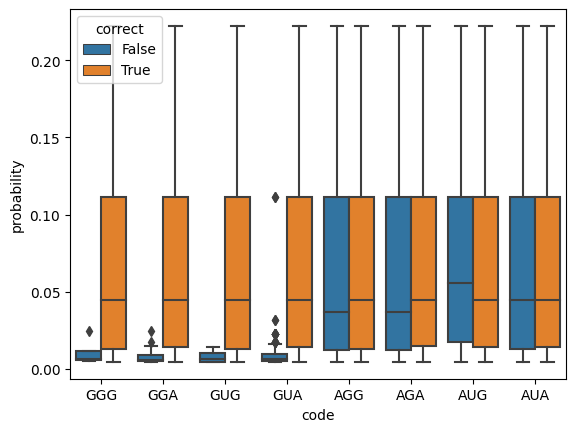

In [6]:
ax = sns.boxplot(data=error_df, y='probability', x='code', hue='correct', orient='v')
ax

<Axes: xlabel='code', ylabel='probability'>

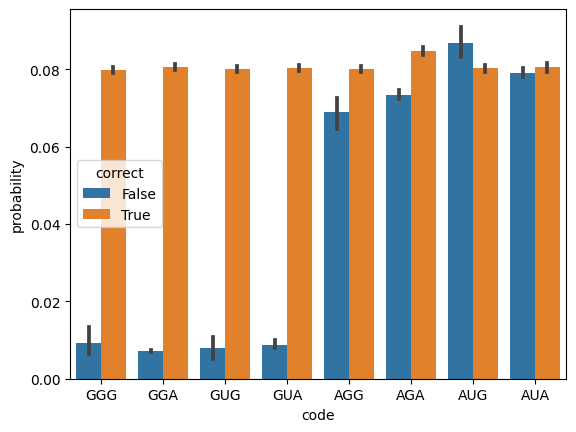

In [7]:
ax = sns.barplot(data=error_df, y='probability', x='code', hue='correct', orient='v')
ax

### Accuracies

In [ ]:
gendered_codes = ["GGG","GGA","AGG","AGA"]
unseen_codes = ["GUG","GUA","AUG","AUA"]

In [9]:
mean = error_df[error_df.code.isin(gendered_codes)].groupby(['training_context','inference_context'])['correct'].mean().unstack()
sem = error_df[error_df.code.isin(gendered_codes)].groupby(['training_context','inference_context'])['correct'].sem().unstack()*1.96
tab1 = mean.combine(sem, lambda m, e: round(m, 4).astype('str') + ' ±' + round(e, 4).astype('str'))

#tab1.to_latex('results/exp_context_or_static/error_analysis/accuracies_G.txt')
tab1

inference_context,ambiguous,gendered
training_context,,
ambiguous,0.538 ±0.0049,0.9695 ±0.0017
gendered,0.9928 ±0.0008,0.9998 ±0.0001


In [10]:
mean = error_df[error_df.code.isin(unseen_codes)].groupby(['training_context','inference_context'])['correct'].mean().unstack()
sem = error_df[error_df.code.isin(unseen_codes)].groupby(['training_context','inference_context'])['correct'].sem().unstack()*1.96
tab2 = mean.combine(sem, lambda m, e: round(m, 4).astype('str') + ' ±' + round(e, 4).astype('str'))

#tab2.to_latex('results/exp_context_or_static/error_analysis/accuracies_U.txt')
tab2

inference_context,ambiguous,gendered
training_context,,
ambiguous,0.5037 ±0.0049,0.9584 ±0.002
gendered,0.9926 ±0.0008,0.9999 ±0.0001
